In [ ]:
import torch
from u2net_test_pseudo_dino_final import U2NET
path = '/home/lis/Utkov/3SD/NEW_STUDENT.pt'
student_encoder = U2NET(3, 1, [320], patch_size=32)
student_encoder.load_state_dict(torch.load(path))
student_encoder.train()

In [ ]:
path = '/home/lis/Utkov/3SD/NEW_STUDENT.pt'
# path = '/home/lis/Utkov/3SD/final_patch32_pseudo_dino_edge_pre_trans_u2net/u2net_bce_epoch_139_train_fulldino.pth'
student_encoder.load_state_dict(torch.load(path))
student_encoder.train()

In [ ]:
data = torch.rand(1,3,320,320).type(torch.FloatTensor)

traced_model = torch.jit.trace(student_encoder, data)
a = traced_model(data)[0]
print(a.shape)
torch.jit.save(traced_model, "traced_model.torchscript")

# torch.jit.load("traced_model.torchscript"), map_location=DEVICE)

/home/lis/Utkov/3SD/venv/lib/python3.10/site-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/lis/Utkov/3SD/model/u2net_transformer_pseudo_dino_final.py:589: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if npatch == N and w == h:


torch.Size([1, 1, 320, 320])


----

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats
def shrink_image(img, max_dim_size):
    h, w = img.shape

    max_old_shape, min_old_shape = (h, w) if h > w else (w, h)
    coeff = max_dim_size / max_old_shape
    max_new_shape, min_new_shape = max_dim_size, round(min_old_shape * coeff)

    h_new, w_new = (max_new_shape, min_new_shape) if h > w else (min_new_shape, max_new_shape)

    img_small = cv2.resize(img, (w_new, h_new), interpolation = cv2.INTER_AREA)
    
    return img_small, coeff

(800, 533)


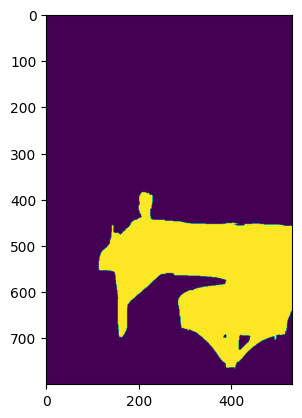

In [40]:
TRESHOLD = 100
# TRESHOLD = 60
# TRESHOLD = 200
MAX_DIM_SIZE = 800

# домики
example = np.load('/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/proj_seminar/output_NEWEST/tomas-malik-jzFyVKqzyaQ-unsplash.npy')[:,:,0]# / 255

# серфёр
# example = np.load('/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/proj_seminar/output_NEWEST/gaspar-zaldo-IHpXq3Tfpb0-unsplash.npy')[:,:,0]# / 255

# стол+ваза
example = np.load('/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/proj_seminar/output_NEWEST/jason-leung-UomtLMysDtk-unsplash.npy')[:,:,0]# / 255

# люди
# example = np.load('/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/proj_seminar/output_NEWEST/venti-views-n7AG4GtbhiM-unsplash.npy')[:,:,0]# / 255

example, _ = shrink_image(example, MAX_DIM_SIZE)

example[example > TRESHOLD] = 255
example[example <= TRESHOLD] = 0
print(example.shape)
plt.imshow(example)

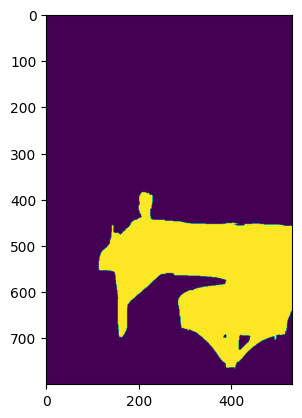

In [41]:
plt.imshow(example)

### Динамический трешхолд

/tmp/ipykernel_1457483/429687000.py:1: RuntimeWarning: overflow encountered in exp
  x = np.exp(np.ravel(example).copy())


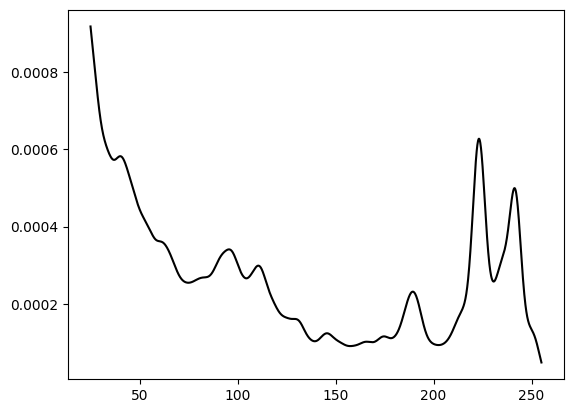

In [13]:
x = np.exp(np.ravel(example).copy())

x = np.ravel(example).copy()
kde = stats.gaussian_kde(np.array(np.ravel(example)))

#visualize KDE
fig = plt.figure()
ax = fig.add_subplot(111)
x_eval = np.linspace(25, 255, num=2000)
ax.plot(x_eval, kde(x_eval), 'k-')

#get probability
# kde.integrate_box_1d( 0.3, np.inf)

/tmp/ipykernel_6724/2660240414.py:1: RuntimeWarning: overflow encountered in exp
  x = np.exp(np.ravel(example).copy())


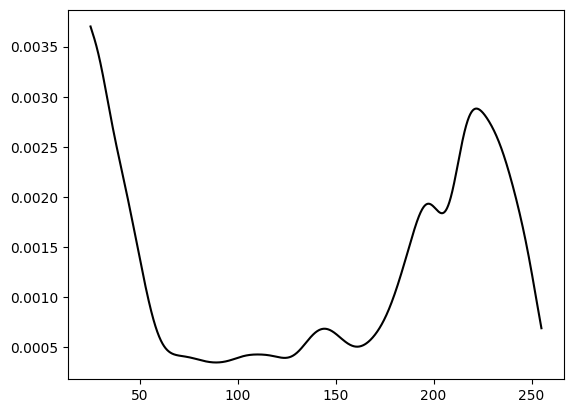

In [77]:
x = np.exp(np.ravel(example).copy())

x = np.ravel(example).copy()
kde = stats.gaussian_kde(np.array(np.ravel(example)))

#visualize KDE
fig = plt.figure()
ax = fig.add_subplot(111)
x_eval = np.linspace(25, 255, num=2000)
ax.plot(x_eval, kde(x_eval), 'k-')

### ----

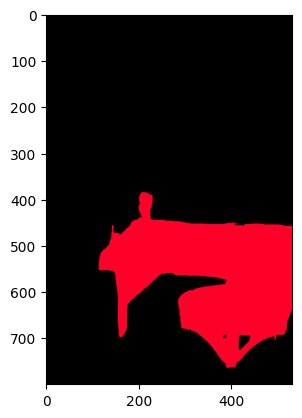

1


In [42]:
from plantcv import plantcv as pcv

# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"
# pcv.params.debug = None

clust_img, clust_masks = pcv.spatial_clustering(mask=example, algorithm="DBSCAN", min_cluster_size=300, max_distance=None)
print(len(clust_masks))


In [101]:
(clust_masks[0]/255).sum()

399.0

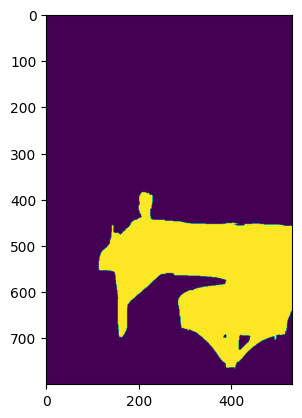

In [43]:
clust_masks[0].shape

plt.imshow(clust_masks[0])

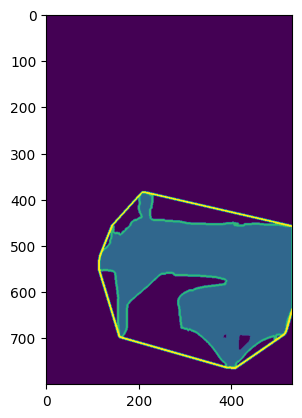

In [44]:
import cv2
 # Поиск контуров на бинарном изображении
contours, _ = cv2.findContours(clust_masks[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_counturs = cv2.drawContours(example.copy() / 255, contours,  -1 , (2,2,2), 3)
max_contourS = max(contours, key=cv2.contourArea)

# добавим обертку
convexHull = cv2.convexHull(max_contourS)
img_counturs = cv2.drawContours(img_counturs, [convexHull], -1, (3, 3, 3), 3)
# Аппроксимируем в четырехугольник (позже подберу коэффициенты)
koef_aprox=[0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02]
koef_iter = iter(koef_aprox)


plt.imshow(img_counturs)

7


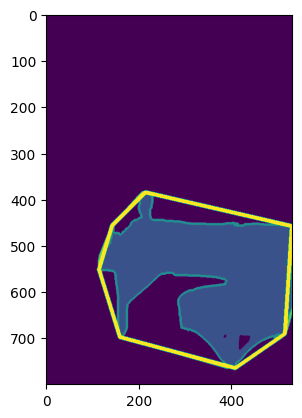

In [53]:
kof = next(koef_iter)

epsilon = kof * cv2.arcLength(convexHull, True) 
f_corners = cv2.approxPolyDP(convexHull, epsilon, True)
    
print(len(f_corners))
image_poly = cv2.polylines(img_counturs.copy(), [f_corners], 
                               isClosed=True, color=(4,4,4), thickness=8)
# convexHull = cv2.convexHull(max_contourS)
# image_poly = cv2.drawContours(image_poly, [convexHull], -1, (4, 4, 4), 6)


plt.imshow(image_poly)

https://stackoverflow.com/questions/249411/comparing-polygons-for-similarity
https://www.cs.cornell.edu/~dph/papers/ACHKM-TPAMI-91.pdf
https://github.com/DBraun/turning-function
https://student.cs.uwaterloo.ca/%7Ecs763/Projects/phil.pdf
https://www.cs.princeton.edu/courses/archive/spr00/cs598b/lectures/polygonsimilarity/polygonsimilarity.pdf
https://medium.com/analytics-vidhya/contours-and-convex-hull-in-opencv-python-d7503f6651bc
https://plantcv.readthedocs.io/en/latest/spatial_clustering/

In [22]:
f_corners

array([[[142, 457]],

       [[530, 458]],

       [[515, 691]],

       [[159, 698]]], dtype=int32)

In [167]:
len(convexHull)

30

In [166]:
import turning_function
turning_function.max_points

1024

In [138]:
img_counturs.shape

(800, 533)

In [ ]:
# Поиск контуров на бинарном изображении
contours, _ = cv2.findContours(list_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.imwrite('/src/app/TEST_AAA/mask_bad_cosine.png', list_mask * 255)
# Выбираем максимальный контур, предполагая что это основная фанера
max_contourS = max(contours, key=cv2.contourArea)
    # Аппроксимируем в четырехугольник (позже подберу коэффициенты)
koef_aprox=[0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02]
for kof in koef_aprox:
    epsilon = kof * cv2.arcLength(max_contourS, True) 
    f_corners = cv2.approxPolyDP(max_contourS, epsilon, True)
    if len(f_corners) >= 4:
        break
    # т.к. требуется адаптация для дальнейших расчетов меняем метами x и y в каждой точке и формируем список в нужном формате
list_corners = [([corner[0][1], corner[0][0]]) for corner in f_corners]

In [ ]:
import cv2
 # Поиск контуров на бинарном изображении
contours, _ = cv2.findContours(example, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.imwrite('/src/app/TEST_AAA/mask_bad_cosine.png', list_mask * 255)
# Выбираем максимальный контур, предполагая что это основная фанера
max_contourS = max(contours, key=cv2.contourArea)
    # Аппроксимируем в четырехугольник (позже подберу коэффициенты)
koef_aprox=[0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02]
for kof in koef_aprox:
    epsilon = kof * cv2.arcLength(max_contourS, True) 
    f_corners = cv2.approxPolyDP(max_contourS, epsilon, True)
    if len(f_corners) >= 4:
        break
# т.к. требуется адаптация для дальнейших расчетов меняем метами x и y в каждой точке и формируем список в нужном формате
list_corners = [([corner[0][1], corner[0][0]]) for corner in f_corners]
list_corners = np.array(sort_points(list_corners))  # top_left, bottom_left, bottom_right, top_right